<a href="https://colab.research.google.com/github/Neruoy/Vision-based-robotic-grasping-system-using-deep-learning/blob/main/DLOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Jun  2 10:43:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
scaler = np.array([[800, 1280] * 4])
def scale_y(y):
  return y / scaler

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import re

file_path ='/content/drive/MyDrive/DLOD/grasp_dataset_arg/done/All'
files = os.listdir(file_path)
image_arrs = []
image_paths = []
label_arrs = []

for file in files:
  try:
    if file[-3:] == 'jpg':
      img, label = file, file.replace('jpg', 'txt')
      if img in files and label in files:
        image_path = os.path.join(file_path, file)
        label_path = image_path.replace('jpg', 'txt')
        label_arr = np.loadtxt(label_path)
        img = img_to_array(load_img(image_path))
        resized_img = tf.image.resize(img, [400, 640], preserve_aspect_ratio=False)
        image_paths.append(image_path)
        image_arrs.append(img_to_array(resized_img))
        label_arrs.append(scale_y(label_arr[:4].reshape(1, -1)))
  except Exception:
    pass

image_arrs = np.array(image_arrs)
label_arrs = np.array(label_arrs)

In [ ]:
image_arrs.shape, label_arrs.shape, len(image_paths)

((634, 400, 640, 3), (634, 1, 8), 634)

In [ ]:
m = image_arrs.shape[0]
BATCH_SIZE = 32
IMG_SIZE = (image_arrs.shape[1], image_arrs.shape[2], image_arrs.shape[3])
IMG_SIZE

(400, 640, 3)

In [ ]:
permutation = list(np.random.permutation(m))
X_shuffled = image_arrs[permutation]
y_shuffled = label_arrs[permutation]

In [ ]:
X_shuffled.shape, y_shuffled.shape

((634, 400, 640, 3), (634, 1, 8))

In [ ]:
X_shuffled_scale = X_shuffled / 255.

In [ ]:
X_valid, X_train = X_shuffled_scale[:60], X_shuffled_scale[60:]
y_valid, y_train = y_shuffled[:60], y_shuffled[60:]

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 640, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 320, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 200, 320, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 200, 320, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
hidden_1 = tf.keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal')
hidden_2 = tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal')
hidden_3 = tf.keras.layers.Dense(50, activation='selu', kernel_initializer='lecun_normal')
prediction_layer = tf.keras.layers.Dense(8)

In [ ]:
inputs = tf.keras.Input(shape=IMG_SIZE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = hidden_1(x)
x = tf.keras.layers.AlphaDropout(0.2)(x)
x = hidden_2(x)
x = tf.keras.layers.AlphaDropout(0.2)(x)
x = hidden_3(x)
x = tf.keras.layers.AlphaDropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 640, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 400, 640, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 400, 640, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 13, 20, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               384300

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Nadam(), loss='mse')

In [ ]:
run_index = 1
run_logdir = os.path.join(os.curdir, "logs", "run_{:03d}".format(run_index))
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 663), started 3:41:46 ago. (Use '!kill 663' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
initial_epochs = 20
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('my_transfer_learning.h5', save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=initial_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
18/18 [==============================] - 9s 236ms/step - loss: 0.9241 - val_loss: 0.2419
Epoch 2/20
18/18 [==============================] - 2s 96ms/step - loss: 0.3209 - val_loss: 0.2535
Epoch 3/20
18/18 [==============================] - 2s 96ms/step - loss: 0.1880 - val_loss: 0.2300
Epoch 4/20
18/18 [==============================] - 2s 96ms/step - loss: 0.1305 - val_loss: 0.1763
Epoch 5/20
18/18 [==============================] - 2s 96ms/step - loss: 0.1001 - val_loss: 0.1503
Epoch 6/20
18/18 [==============================] - 2s 97ms/step - loss: 0.0843 - val_loss: 0.1462
Epoch 7/20
18/18 [==============================] - 2s 96ms/step - loss: 0.0789 - val_loss: 0.1694
Epoch 8/20
18/18 [==============================] - 2s 96ms/step - loss: 0.0766 - val_loss: 0.1653
Epoch 9/20
18/18 [==============================] - 2s 96ms/step - loss: 0.0736 - val_loss: 0.1116
Epoch 10/20
18/18 [==============================] - 2s 95ms/step - loss: 0.0734 - val_loss: 0.1471
Epoch 11

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

Number of layers in the base model:  154


In [ ]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss='mse',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10))

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 400, 640, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 400, 640, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 400, 640, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 13, 20, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               384300

In [ ]:
fine_tune_epochs = 300
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(X_train, y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_valid, y_valid),
                         callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 20/320


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


18/18 [==============================] - 9s 245ms/step - loss: 0.0695 - val_loss: 0.1391
Epoch 21/320
18/18 [==============================] - 2s 135ms/step - loss: 0.0693 - val_loss: 0.1380
Epoch 22/320
18/18 [==============================] - 2s 135ms/step - loss: 0.0693 - val_loss: 0.1369
Epoch 23/320
18/18 [==============================] - 2s 133ms/step - loss: 0.0692 - val_loss: 0.1360
Epoch 24/320
18/18 [==============================] - 2s 133ms/step - loss: 0.0691 - val_loss: 0.1351
Epoch 25/320
18/18 [==============================] - 2s 134ms/step - loss: 0.0691 - val_loss: 0.1343
Epoch 26/320
18/18 [==============================] - 2s 135ms/step - loss: 0.0690 - val_loss: 0.1338
Epoch 27/320
18/18 [==============================] - 2s 134ms/step - loss: 0.0691 - val_loss: 0.1332
Epoch 28/320
18/18 [==============================] - 2s 133ms/step - loss: 0.0692 - val_loss: 0.1334
Epoch 29/320
18/18 [==============================] - 2s 134ms/step - loss: 0.0693 - val_loss: 

In [ ]:
final_model = tf.keras.models.load_model("my_transfer_learning.h5")

In [ ]:
final_model.evaluate(X_valid, y_valid)

2/2 [==============================] - 1s 73ms/step - loss: 0.1116


0.11155425757169724

In [ ]:
test_file_path ='/content/drive/MyDrive/DLOD/grasp_dataset'
test_files = os.listdir(test_file_path)
test_image_paths = []
test_image_arrs = []

for file in test_files:
  try:
    if file[-3:] == 'png':
      test_image_path = os.path.join(test_file_path, file)
      test_img = load_img(test_image_path)
      test_img_arr = img_to_array(load_img(test_image_path))
      resized_test_img = tf.image.resize(test_img_arr, [400, 640])
      test_image_paths.append(test_image_path)
      test_image_arrs.append(img_to_array(resized_test_img))
  except Exception:
    pass

test_image_arrs = np.array(test_image_arrs)

In [ ]:
test_image_arrs.shape, len(test_image_paths)

((47, 400, 640, 3), 47)

In [ ]:
x_test, x_test_path = test_image_arrs[:1], test_image_paths[0]
x_test.shape

(1, 400, 640, 3)

In [ ]:
y_test = final_model.predict(x_test)
y_test.shape

(1, 8)

In [ ]:
y_test

array([[0.9285027 , 0.38358217, 0.88795906, 0.32566983, 0.8220353 ,
        0.47178656, 0.7639811 , 0.581541  ]], dtype=float32)

In [ ]:
y_test_rescale = y_test * scaler
y_test_rescale

array([[742.8021431 , 490.98518372, 710.36725044, 416.8573761 ,
        657.62825012, 603.88679504, 611.18488312, 744.3724823 ]])

In [ ]:
y_test_rescale[:, 6:8]

array([[611.18488312, 744.3724823 ]])

In [ ]:
def get_points(y_arr):
  pt1 = y_arr[:, :2].ravel()
  pt2 = y_arr[:, 2:4].ravel()
  pt3 = y_arr[:, 4:6].ravel()
  pt4 = y_arr[:, 6:8].ravel()
  return pt1, pt2, pt3, pt4

In [ ]:
pt1, pt2, pt3, pt4 = get_points(y_test_rescale)
pt1

array([742.8021431 , 490.98518372])

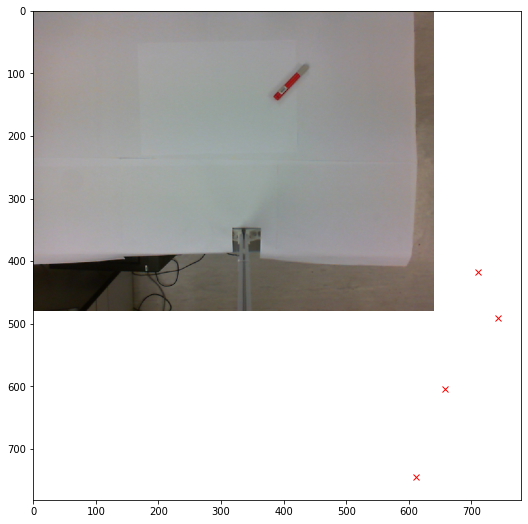

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

f = plt.figure(figsize=(16, 9))
x_test_img = mpimg.imread(x_test_path)
plt.imshow(x_test_img)
plt.plot(pt1[0], pt1[1], 'rx')
plt.plot(pt2[0], pt2[1], 'rx')
plt.plot(pt3[0], pt3[1], 'rx')
plt.plot(pt4[0], pt4[1], 'rx')
plt.show()

In [ ]:
x_train_test = X_shuffled_scale[4]
y_train_test = y_shuffled[4] * scaler
y_train_test

array([[872., 506., 852., 506., 852., 585., 872., 585.]])

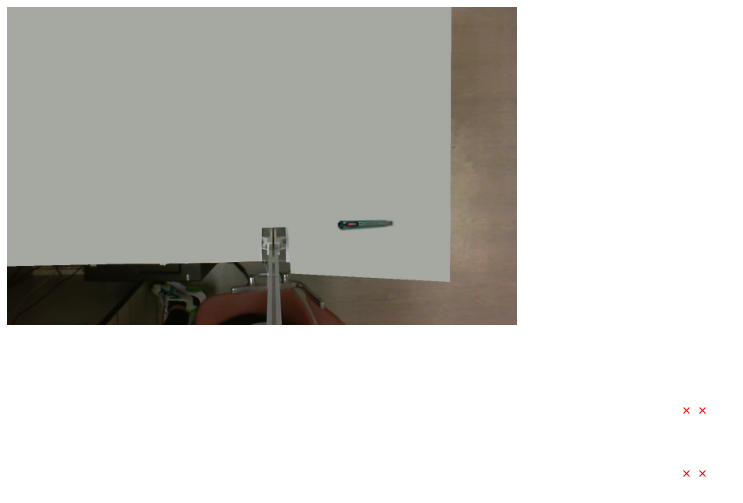

In [ ]:
pt1, pt2, pt3, pt4 = get_points(y_train_test)

f2 = plt.figure(figsize=(16, 9))
plt.axis(False)
plt.imshow(x_train_test[0])
plt.plot(pt1[0], pt1[1], 'rx')
plt.plot(pt2[0], pt2[1], 'rx')
plt.plot(pt3[0], pt3[1], 'rx')
plt.plot(pt4[0], pt4[1], 'rx')
plt.show()

In [ ]:
x_train_test = X_shuffled_scale[4:5, :, :, :]
y_pred = final_model.predict(x_train_test)
y_pred = y_pred * scaler
y_pred.shape

(1, 8)

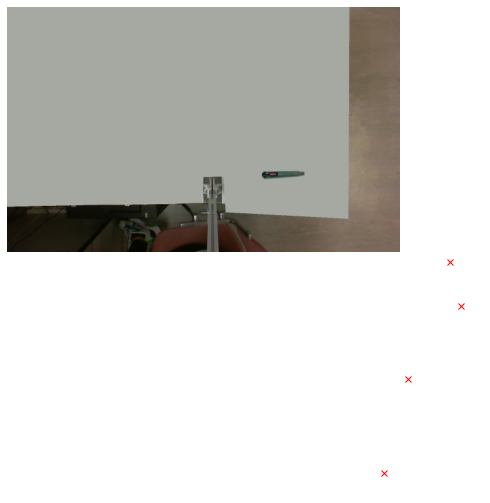

In [ ]:
pt1, pt2, pt3, pt4 = get_points(y_pred)

f2 = plt.figure(figsize=(16, 9))
plt.axis(False)
plt.imshow(x_train_test[0])
plt.plot(pt1[0], pt1[1], 'rx')
plt.plot(pt2[0], pt2[1], 'rx')
plt.plot(pt3[0], pt3[1], 'rx')
plt.plot(pt4[0], pt4[1], 'rx')
plt.show()